# Trying to close wmt budget

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import gcsfs
import gcm_filters
import xgcm
from xhistogram.xarray import histogram
from typing import Annotated

In [2]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
surf_ds  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [3]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [6]:
tendencies = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/tendencies_outliers_rm.zarr'))

In [3]:
tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/tracer_tend_outlier_rm.zarr'))
#tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/tracer_tendencies.zarr'))
drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/drhodts_tendencies.zarr'))
#cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/cabbeling.zarr'))
cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/cabbeling_outliers_rm.zarr'))
rho_lap = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho_lap.zarr'))

rho = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))

tend = xr.merge([tracers, cab, rho_lap, drhodts])

In [5]:
tend

<xarray.Dataset>
Dimensions:    (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    sss        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    sst        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [5]:
#New ds after dthetadt*drhodt and dSdt*drhods
def new_ds(ds):
    newds = xr.merge([(ds['SST_lap']*ds['drhodt']).rename('sst'),
                      (ds['SSS_lap']*ds['drhods']).rename('sss'),
                       ds['rho_lap'],
                       ds['cabbeling']])
    return newds

In [6]:
tendencies = new_ds(tend)

In [7]:
res = tendencies.rho_lap + tendencies.cabbeling - tendencies.sss - tendencies.sst

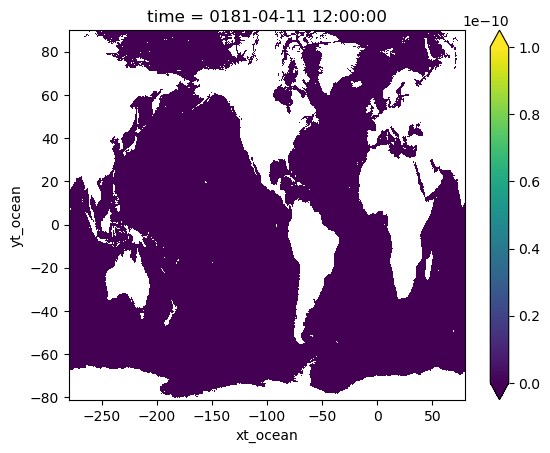

In [8]:
res.isel(time=100).plot(robust=True, vmin=1e-10);

## Run histogram and check residual

In [9]:
delta_rho = 0.1
rho_bins = np.arange(1015, 1035, delta_rho)
avg_mld = ds.mld.mean('time').compute()
weights = coord.area_t*avg_mld

In [10]:
def global_hist_func(ds, variable):
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                    weights=(ds[variable].fillna(0.)*weights.fillna(0.)),
                    dim=['xt_ocean', 'yt_ocean']) / delta_rho
    return hist

In [11]:
all_tendencies = list(tendencies.data_vars)

In [12]:
global_hists = xr.merge([global_hist_func(tendencies, var).rename('OMEGA_' + var) for var in all_tendencies])

NameError: name 'rho' is not defined

In [13]:
global_hists

NameError: name 'global_hists' is not defined

In [26]:
residual = global_hists.OMEGA_rho_lap + global_hists.OMEGA_cabbeling - global_hists.OMEGA_sss - global_hists.OMEGA_sst

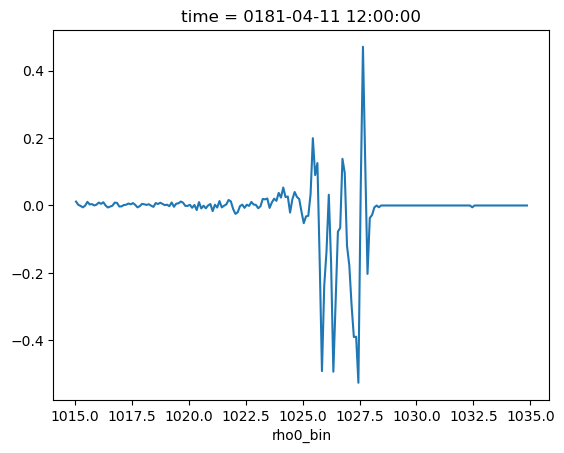

In [31]:
(residual/1e6).isel(time=100).plot()